origin: http://pytorch.org/tutorials/beginner/pytorch_with_examples.html  
translator: Hongpu Liu

In [1]:
%matplotlib inline
from __future__ import print_function

# 流程控制与权重共享
作为动态图与权重共享的例子，下面要实现一个非常古怪的模型：一个全连接ReLU网络。每一次前馈选择一个1到4之间的随机数，并使用相同数量的隐层，中间的隐层将使用相同的权重。

在下面的模型中，使用了正常的Python流程控制语句来实现循环，通过多次重用模块来进行权重共享。

下面的例子中，该模型被定义为Module的一个子类：

In [2]:
import random
import torch
from torch.autograd import Variable

class DynamicNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        在构造器中定义三个前馈过程将要使用的nn.Linear示例
        """
        super(DynamicNet, self).__init__()
        self.input_linear = torch.nn.Linear(D_in, H)
        self.middle_linear = torch.nn.Linear(H, H)
        self.output_linear = torch.nn.Linear(H, D_out)
        
    def forward(self, x):
        """
        对于模型的前馈过程，随机重用middle_linear模块多次（0、1、2或3）来计算隐层表示
        
        由于前馈过程会构建动态图，可以直接使用标准的Python流程控制操作来定义前馈传播。
        
        下面的例子中可以看到，在定义计算图时，重用同一个模块多次是非常安全的。
        """
        h_relu = self.input_linear(x).clamp(min=0)
        for _ in range(random.randint(0, 3)):
            h_relu = self.middle_linear(h_relu).clamp(min=0)
        y_pred = self.output_linear(h_relu)
        return y_pred
    
# N     ：样本的数量，本例采用批量梯度下降，每次训练使用全部的样本
# D_in  ：输入特征的维度
# H     ：隐层神经元的数量
# D_out ：输出层维度
N, D_in, H, D_out = 64, 1000, 100, 10

# 创建存储输入和输出的张量，并将他们封装到变量中
x = Variable(torch.randn(N, D_in)) # 默认情况下，requires_grad为False
y = Variable(torch.randn(N, D_out), requires_grad=False)

# 用自定义模块来实例化模型
model = DynamicNet(D_in, H, D_out)

# 构造损失函数与优化器。训练该模型使用普通的随机梯度下降比较困难，因此使用冲量。
criterion = torch.nn.MSELoss(size_average=False)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)

losses = []

for t in range(500):
    # 前馈传播：将x传递给模型，计算y的预测值
    y_pred = model(x)
    
    # 计算和打印loss
    loss = criterion(y_pred, y)
    print(t, loss.data[0])

    losses.append(loss.data[0])
    
    # 清零梯度缓存、执行反向传播和更新权重
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 692.203125
1 702.426940918
2 689.446899414
3 682.377502441
4 666.344482422
5 646.078125
6 683.750366211
7 732.120300293
8 593.376464844
9 578.562194824
10 679.999450684
11 674.385559082
12 535.540771484
13 553.530761719
14 505.051940918
15 433.758483887
16 485.278381348
17 675.545349121
18 448.895050049
19 644.000488281
20 393.219390869
21 357.328033447
22 157.980209351
23 282.820465088
24 627.782714844
25 607.088500977
26 574.597839355
27 440.931396484
28 474.337432861
29 413.040130615
30 337.450958252
31 338.037780762
32 336.717773438
33 377.601715088
34 300.613372803
35 243.250930786
36 195.485626221
37 187.224517822
38 231.510543823
39 136.788467407
40 183.500061035
41 214.025238037
42 90.4643630981
43 207.362197876
44 149.109344482
45 224.769500732
46 88.8361740112
47 261.169891357
48 121.337440491
49 190.478561401
50 138.503067017
51 100.094543457
52 130.547149658
53 69.8575210571
54 107.707832336
55 105.652503967
56 171.833267212
57 89.4182739258
58 99.8167800903
59 100.192321

486 0.289122253656
487 0.169672355056
488 0.770192980766
489 0.213181599975
490 0.301007091999
491 0.221276342869
492 0.783690452576
493 0.0466326586902
494 0.24858532846
495 0.778907418251
496 0.210157036781
497 0.540958404541
498 0.197805166245
499 0.443481117487


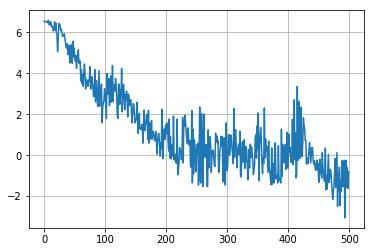

In [3]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.log(losses))
plt.grid()